In [1]:
# 🚀 Auto-setup: installs deps + configures CFBD access
import os
import sys
from pathlib import Path

# Find _auto_setup.py regardless of current working directory
_current = Path().resolve()
_auto_setup_path = None
for parent in [_current] + list(_current.parents):
    candidate = parent / "starter_pack" / "_auto_setup.py"
    if candidate.exists():
        _auto_setup_path = candidate
        # Add project root to sys.path (auto_setup.py will also do this)
        if str(parent) not in sys.path:
            sys.path.insert(0, str(parent))
        break

if _auto_setup_path and _auto_setup_path.exists():
    # Execute the file directly without changing directory
    with open(_auto_setup_path, 'r') as f:
        exec(f.read(), {'__file__': str(_auto_setup_path)})
else:
    # Fallback: try relative path
    try:
        with open("./_auto_setup.py", 'r') as f:
            exec(f.read(), {'__file__': './_auto_setup.py'})
    except FileNotFoundError:
        print("⚠️  Could not find _auto_setup.py. Please run from starter_pack directory.")


ModuleNotFoundError: No module named 'starter_pack'

In [2]:
# 04_team_similarity.ipynb
# 🔍 Team Similarity Using K-Nearest Neighbors (KNN)

# 🛠 Requirements:
# - pandas, scikit-learn, matplotlib, seaborn (install via `pip install pandas scikit-learn matplotlib seaborn`)

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sys
from pathlib import Path

# Import starter pack configuration system
_config_dir = Path().resolve() / "config"
if str(_config_dir.parent) not in sys.path:
    sys.path.insert(0, str(_config_dir.parent))
from config.data_config import get_starter_pack_config

# Get configuration
config = get_starter_pack_config()
current_year = config.current_year
DATA_DIR = str(config.data_dir)

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,8]


In [3]:
# 📂 Load team-level advanced season stats

stats_path = str(config.get_advanced_stats_path(year=current_year))
stats = pd.read_csv(stats_path)

# Filter to FBS teams
teams = stats[stats['conference'].notnull()].copy()

# Drop teams with missing metrics
metrics = [
    'offense_ppa', 'offense_successRate', 'offense_explosiveness',
    'defense_ppa', 'defense_successRate', 'defense_explosiveness',
    'offense_lineYards', 'offense_secondLevelYards', 'offense_pointsPerOpportunity',
    'defense_lineYards', 'defense_secondLevelYards', 'defense_pointsPerOpportunity'
]

teams = teams.dropna(subset=metrics)
teams = teams.reset_index(drop=True)
print(f"{len(teams)} teams with full data for {current_year}")


136 teams with full data for 2025


In [4]:
# 🧪 Standardize features for similarity analysis

X = teams[metrics].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:
# 🧭 Fit KNN model (Euclidean distance)

knn = NearestNeighbors(n_neighbors=6, metric='euclidean')  # 5 neighbors + the team itself
knn.fit(X_scaled)

# Lookup table for team names
team_names = teams['team'].tolist()


In [6]:
# 🔍 Find similar teams to a given team
def find_similar_teams(team_name, top_n=5):
    try:
        idx = team_names.index(team_name)
    except ValueError:
        print(f"Team '{team_name}' not found.")
        return
    
    distances, indices = knn.kneighbors([X_scaled[idx]])
    
    print(f"Most similar teams to {team_name} (current_year):")
    for i in range(1, top_n + 1):  # skip index 0 (itself)
        team_idx = indices[0][i]
        print(f" - {team_names[team_idx]} (distance: {distances[0][i]:.3f})")

# Example usage
find_similar_teams("Michigan")


Most similar teams to Michigan (current_year):
 - Iowa (distance: 2.379)
 - BYU (distance: 2.680)
 - Missouri (distance: 3.015)
 - Kentucky (distance: 3.130)
 - Louisville (distance: 3.272)


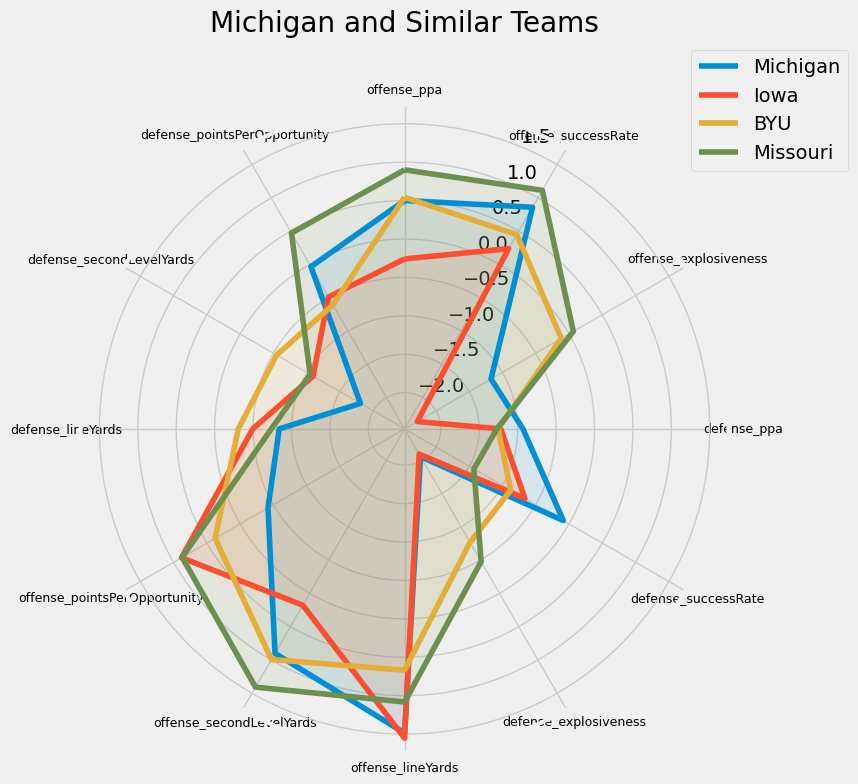

In [7]:
# 📊 Optional: Visualize your selected team vs. similar teams

def plot_similarity_radar(team_name):
    from math import pi
    
    idx = team_names.index(team_name)
    _, indices = knn.kneighbors([X_scaled[idx]])
    
    compare_idxs = indices[0][1:4]  # top 3 similar teams
    
    subset = teams.loc[[idx] + compare_idxs.tolist()]
    subset_scaled = pd.DataFrame(X_scaled[[idx] + compare_idxs.tolist()], columns=metrics)
    subset_scaled['team'] = subset['team'].values

    # Radar chart prep
    categories = metrics
    N = len(categories)

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for _, row in subset_scaled.iterrows():
        values = row[categories].tolist()
        values += values[:1]  # close the circle
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]
        ax.plot(angles, values, label=row['team'])
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks([n / float(N) * 2 * pi for n in range(N)])
    ax.set_xticklabels(categories, fontsize=9)
    ax.set_title(f"{team_name} and Similar Teams", y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.show()

# Example
plot_similarity_radar("Michigan")


In [8]:
# ✅ Summary

# In this notebook, you:
# - Loaded and standardized team metrics
# - Used KNN to find the most similar teams
# - Built a simple tool to explore team profiles
# - Visualized teams with radar plots

# 🧪 Try This:
# - Cluster teams using KMeans or DBSCAN
# - Compare year-over-year similarity for a single team
# - Build a matchup tool using similarity + next opponent